Project: # Patil_ADEarlyDetection

# **Phase 1:**  
## CNN with TL = DenseNet201




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/AD_proj"

Mounted at /content/drive
Alzheimer_s_Dataset  proj_ADEarlyDetection_densenet201_rev0.ipynb
my_best_models


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, save_model
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.applications.densenet import DenseNet201
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import IPython
import itertools

# Plot libs
from matplotlib import pyplot as plt
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('/content/drive/My Drive/AD_proj')

#
# Define constants
#
NUM_EPOCH = 100
NUM_PATIENCE =20
NUM_VAL_SPLIT = 0.2
NUM_IMG_RESCALE = 1/255
NUM_BATCH_SIZE = 128
NUM_IMAGE_SIZE =224
NUM_LEARNING_RATE = 0.001

target_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
train = ImageDataGenerator(validation_split=NUM_VAL_SPLIT,
                           rotation_range=40,
                           zoom_range=0.2,
                           horizontal_flip=True, 
                           vertical_flip=True, 
                           rescale=NUM_IMG_RESCALE)

validation = ImageDataGenerator(validation_split=NUM_VAL_SPLIT, rescale=NUM_IMG_RESCALE)

test = ImageDataGenerator(rescale=NUM_IMG_RESCALE)

train_dataset = train.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='training')
val_dataset = validation.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='validation')

test_dataset = test.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/test', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical')

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
#--------------------------------------------------------------------
# Function Name: f_ad_model_builder
# Description: Build Convolutional Neural Network (CNN) Deep learning model
#              for early diagnosis of Alzheimer's disease
# Output : 4 output classes 
#--------------------------------------------------------------------
def f_ad_model_builder():
    
  #model_densenet169 = DenseNet169(input_shape=(NUM_IMAGE_SIZE,NUM_IMAGE_SIZE,3), include_top=False, weights="imagenet")
  model_densenet201 = DenseNet201(input_shape=(NUM_IMAGE_SIZE,NUM_IMAGE_SIZE,3), include_top=False, weights="imagenet")

  #print('----------- Transfer Layer ---------\n')
  #model_densenet201.summary()
  #print('------------------------------------\n')

  # freeze layers
  for layer in model_densenet201.layers :
    layer.trainable = False

  model = Sequential()
  model.add(model_densenet201)
  model.add(Dropout(0.5))

  model.add(Flatten())
  
  model.add(BatchNormalization())
  model.add(Dense(2048,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4,activation='softmax'))

  model.summary()

  #
  # COMPILE: Tune the learning rate for the optimizer value choice 
  # from 0.01, 0.001, or 0.0001
  # 
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = NUM_LEARNING_RATE),
                loss = 'categorical_crossentropy', 
                metrics = [tf.keras.metrics.AUC(name = 'auc')])
  
  return model

#--------------------------------------------------------------------
# Function Name: f_all_ad_plot_model
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_all_plot_model(hist):

    plt.plot(hist.history["acc"])
    plt.plot(hist.history['val_acc'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("AD Early Detection Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation Loss"])

    # Show the plot
    plt.show()

#--------------------------------------------------------------------
# Function Name: f_ad_plot_auc_loss
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_plot_auc_loss(f_model):

  # create subplots
  fig, axs = plt.subplots(1,2,figsize=(15,10))

  ticks = np.arange(1,len(f_model.history['loss'])+1)
  history_auc_length = len(f_model.history['auc'])+1
  history_val_auc_length = len(f_model.history['val_auc'])+1
  history_loss_length = len(f_model.history['loss'])+1
  history_val_loss_length = len(f_model.history['val_loss'])+1

  # Summarize history for auc
  axs[0].plot(range(1,history_auc_length), f_model.history['auc'])
  axs[0].plot(range(1,history_val_auc_length), f_model.history['val_auc'])
  axs[0].set_title('Model AUC')
  axs[0].set_ylabel('AUC')
  axs[0].set_xlabel('Epoch')
  axs[0].set_xticks(ticks,len(f_model.history['auc'])/10)
  axs[0].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

  # Summarize history for loss
  axs[1].plot(range(1, history_loss_length), f_model.history['loss'])
  axs[1].plot(range(1,history_val_loss_length), f_model.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_xticks(ticks,len(f_model.history['loss'])/10)
  axs[1].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

#--------------------------------------------------------------------
# Function Name: plot_confusion_matrix
# Description: 
# source code from : scikit-learn.org
#--------------------------------------------------------------------
def f_ad_plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

#--------------------------------------------------------------------
# Function Name: 
# Description: 
#              
#--------------------------------------------------------------------
# ??? how to calculate fpr/tpr
def f_ad_plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, 'b',color='orange', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate (FPR) ')
    plt.ylabel('True Positive Rate (TPR) ')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc = 'lower right')
    plt.show()
#--------------------------------------------------------------------
# Function Name: f_ad_plot_model
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_plot_acc_loss(f_model):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,10))
    ticks = np.arange(1,len(f_model.history['loss'])+1)
    history_acc_length = len(f_model.history['accuracy'])+1
    history_val_accuracy_length = len(f_model.history['val_accuracy'])+1
    history_loss_length = len(f_model.history['loss'])+1
    history_val_loss_length = len(f_model.history['val_loss'])+1

    # Summarize history for accuracy
    axs[0].plot(range(1,history_acc_length), f_model.history['accuracy'])
    axs[0].plot(range(1,history_val_accuracy_length), f_model.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(ticks,len(f_model.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1, history_loss_length), f_model.history['loss'])
    axs[1].plot(range(1,history_val_loss_length), f_model.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(ticks,len(f_model.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

74842112/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1920)        0         
_________________________________________________________________
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 94080)             376320    
_________________________________________________________________
dense (Dense)                (None, 2048)              192677888 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


total 3617098
-rw------- 1 root root 1288972184 Dec 30 21:57 densenet121_rev0.hdf5
-rw------- 1 root root 2414935056 Jan  9 10:55 densenet201_rev0.hdf5


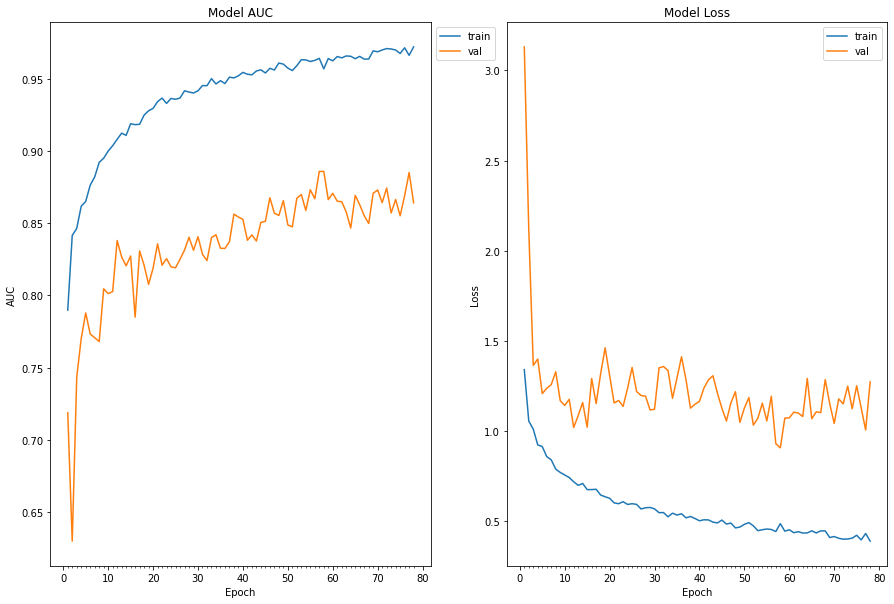

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/AD_proj/my_best_models/densenet201_rev0.hdf5", monitor='val_auc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_auc', min_delta=0, patience=NUM_PATIENCE, verbose=1, mode='max') 

model = f_ad_model_builder()
model_history=model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs = NUM_EPOCH,
                        callbacks = [checkpoint, early],
                        verbose = 2)

print('--------------------------------------------\n')
print('Results:')
f_ad_plot_auc_loss(model_history)

!ls -al '/content/drive/My Drive/AD_proj/my_best_models'


Evaluate on test data
10/10 [==============================] - 174s 19s/step - loss: 1.0939 - auc: 0.8898
test loss, test auc: [1.0938606262207031, 0.8898263573646545]
-----------------------------------------------------
Classification Report [test DataSet]
                  precision    recall  f1-score   support

    MildDemented       0.22      0.06      0.10       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      0.61      0.55       640
VeryMildDemented       0.38      0.37      0.37       448

        accuracy                           0.44      1279
       macro avg       0.27      0.26      0.26      1279
    weighted avg       0.41      0.44      0.42      1279

-----------------------------------------------------
Confusion matrix, without normalization
[[ 11   1 112  55]
 [  0   0   6   6]
 [ 28   9 391 212]
 [ 12   3 267 166]]


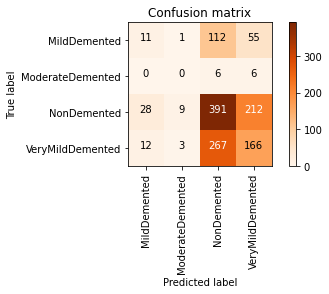

In [ ]:
#
# load model
#
loaded_model = load_model(filepath='/content/drive/My Drive/AD_proj/my_best_models/densenet201_rev0.hdf5')

print("Evaluate on test data")
test_results = loaded_model.evaluate(test_dataset, batch_size=NUM_BATCH_SIZE)
print("test loss, test auc:", test_results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
test_pred = loaded_model.predict(test_dataset)
test_pred_classes = np.argmax(test_pred, axis=1)

#print ('-----------------------------------------------------')
#print('Confusion Matrix [test DataSet]')
cm = confusion_matrix(test_dataset.classes, test_pred_classes)

print ('-----------------------------------------------------')
print('Classification Report [test DataSet]')
print(classification_report(test_dataset.classes, test_pred_classes, target_names=target_names))

print ('-----------------------------------------------------')
#plot the matrix
f_ad_plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges)

-----------------------------------------------------
Normalized confusion matrix
[[0.06145251 0.00558659 0.62569832 0.30726257]
 [0.         0.         0.5        0.5       ]
 [0.04375    0.0140625  0.6109375  0.33125   ]
 [0.02678571 0.00669643 0.59598214 0.37053571]]


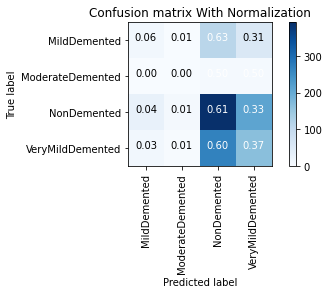

In [ ]:
print ('-----------------------------------------------------')
#plot the matrix
f_ad_plot_confusion_matrix(cm, target_names, normalize=True, title='Confusion matrix With Normalization', cmap=plt.cm.Blues)